[View in Colaboratory](https://colab.research.google.com/gist/naviarh/e9ff9583d6587d619c845f9518b949e3/fastai2.ipynb)

# Обучение на структурированных данных
Типы структурированных данных (признаков):
- категориальные
- Количественные

Для категориальных признаков применяется метод эмбеддинга

3 способ передачи данных (структурированных) нейросети - датафрейм (таблица)

(Для неструтурированных данных - размещение по каталогам или по файлу разметки csv )

Алгоритм:
1. Находим все возможные полезные признаки;
2. Разделяем признаки на количественные и категориальные;
3. Формируем датафрейм признаков;
4. Создаём валидационную выборку;
5. Объект данных (ColumnarModelData.from_data_frame())
6. Создаём массив размеров матриц эмбеддинга
7. Создаём алгоритм обучения (моделль нейросети)
8. Обучаем модель


In [0]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

In [0]:
!pip install --upgrade pip
!pip3 install fastai

In [3]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!pwd

/content


In [4]:
import subprocess, os
os.uname()

posix.uname_result(sysname='Linux', nodename='54c7ac56ac31', release='4.14.33+', version='#1 SMP Wed Jun 20 01:36:48 PDT 2018', machine='x86_64')

In [7]:
from fastai.structured import *
from fastai.column_data import *
!pip3 show fastai torch | grep Name -A 1

Name: fastai
Version: 0.7.0
--
Name: torch
Version: 0.3.1


In [0]:
#from fastai.imports import *
#from fastai.transforms import *
#from fastai.conv_learner import *
#from fastai.model import *
#from fastai.dataset import *
#from fastai.sgdr import *
#from fastai.plots import *
#!pip3 show fastai torch | grep Name -A 1

In [9]:
torch.cuda.set_device(0)
torch.cuda.get_device_name(0)

'Tesla K80'

In [0]:
# Устанавливаем формат показа массивов numpy
np.set_printoptions(threshold=50, edgeitems=20)

### Исходные данные

In [0]:
# Создадим путь к каталогу PATH
PATH='data/rossmann/'
os.makedirs(PATH, exist_ok=True)

In [13]:
# Скачаем нужные данные
!wget http://files.fast.ai/part2/lesson14/rossmann.tgz

--2018-07-28 10:23:00--  http://files.fast.ai/part2/lesson14/rossmann.tgz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7730448 (7.4M) [text/plain]
Saving to: ‘rossmann.tgz’

rossmann.tgz        100%[===================>]   7.37M  9.86MB/s    in 0.7s    

2018-07-28 10:23:01 (9.86 MB/s) - ‘rossmann.tgz’ saved [7730448/7730448]



In [20]:
# Распакуем данные
!tar zxvf rossmann.tgz -C {PATH}

googletrend.csv
sample_submission.csv
state_names.csv
store.csv
store_states.csv
test.csv
train.csv
weather.csv


Feature Space:
- googletrend: trend of certain google keywords over time, found by users to correlate well given data
- List of German state names
- store: List of stores
- store_states: mapping of store to the German state they are in
- test: testing set
- train: Training set provided by competition
- weather: weather

In [0]:
# Функция объединения данных
def concat_csvs(dirname):
    path = f'{PATH}{dirname}'
    filenames=glob(f"{PATH}/*.csv")

    wrote_header = False
    with open(f"{path}.csv","w") as outputfile:
        for filename in filenames:
            name = filename.split(".")[0]
            with open(filename) as f:
                line = f.readline()
                if not wrote_header:
                    wrote_header = True
                    outputfile.write("file,"+line)
                for line in f:
                     outputfile.write(name + "," + line)
                outputfile.write("\n")

In [0]:
# concat_csvs('googletrend')
# concat_csvs('weather')

In [0]:

table_names = ['train', 'store', 'store_states', 'state_names', 'googletrend', 'weather', 'test']
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [0]:
from IPython.display import HTML, display

In [25]:
# Посмотрим как выглядят данные в таблицах
for t in tables: display(t.head())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN


,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY
2,Berlin,BE
3,Brandenburg,BB
4,Bremen,HB


,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,...,11.0,5.0,2.0,23,14,NaN,0.25,7.0,Rain,263
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,...,10.0,6.0,3.0,16,10,NaN,0.00,7.0,Rain,268


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [26]:
# Сводная информация по таблицам
for t in tables: display(DataFrameSummary(t).summary())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1.01721e+06,1.01721e+06,NaN,1.01721e+06,1.01721e+06,1.01721e+06,1.01721e+06,NaN,1.01721e+06
mean,558.43,3.99834,NaN,5773.82,633.146,0.830107,0.381515,NaN,0.178647
std,321.909,1.99739,NaN,3849.93,464.412,0.375539,0.485759,NaN,0.383056
min,1,1,NaN,0,0,0,0,NaN,0
25%,280,2,NaN,3727,405,1,0,NaN,0
50%,558,4,NaN,5744,609,1,0,NaN,0
75%,838,6,NaN,7856,837,1,1,NaN,0
max,1115,7,NaN,41551,7388,1,1,NaN,1
counts,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209
uniques,1115,7,942,21734,4086,2,2,4,2


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1115,NaN,NaN,1112,761,761,1115,571,571,NaN
mean,558,NaN,NaN,5404.9,7.2247,2008.67,0.512108,23.5954,2011.76,NaN
std,322.017,NaN,NaN,7663.17,3.21235,6.19598,0.500078,14.142,1.67494,NaN
min,1,NaN,NaN,20,1,1900,0,1,2009,NaN
25%,279.5,NaN,NaN,717.5,4,2006,0,13,2011,NaN
50%,558,NaN,NaN,2325,8,2010,1,22,2012,NaN
75%,836.5,NaN,NaN,6882.5,10,2013,1,37,2013,NaN
max,1115,NaN,NaN,75860,12,2015,1,50,2015,NaN
counts,1115,1115,1115,1112,761,761,1115,571,571,571
uniques,1115,4,3,654,12,23,2,24,7,3


,Store,State
count,1115,NaN
mean,558,NaN
std,322.017,NaN
min,1,NaN
25%,279.5,NaN
50%,558,NaN
75%,836.5,NaN
max,1115,NaN
counts,1115,1115
uniques,1115,12


,StateName,State
count,16,16
unique,16,16
top,RheinlandPfalz,HB
freq,1,1
counts,16,16
uniques,16,16
missing,0,0
missing_perc,0%,0%
types,unique,unique


,file,week,trend
count,NaN,NaN,2072
mean,NaN,NaN,63.8142
std,NaN,NaN,12.6502
min,NaN,NaN,0
25%,NaN,NaN,55
50%,NaN,NaN,64
75%,NaN,NaN,72
max,NaN,NaN,100
counts,2072,2072,2072
uniques,14,148,68


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
count,NaN,NaN,15840,15840,15840,15840,15840,15840,15840,15840,...,15459,15459,15459,15840,15840,3604,15840,14667,NaN,15840
mean,NaN,NaN,14.6441,10.389,6.19899,8.58782,6.20581,3.62614,93.6596,74.2829,...,24.0576,12.2398,7.02516,22.7666,11.9722,48.8643,0.831718,5.55131,NaN,175.897
std,NaN,NaN,8.64601,7.37926,6.52639,6.24478,6.08677,6.12839,7.67853,13.4866,...,8.9768,5.06794,4.9806,8.98862,5.87284,13.027,2.51351,1.68771,NaN,101.589
min,NaN,NaN,-11,-13,-15,-14,-15,-73,44,30,...,0,0,0,3,2,21,0,0,NaN,-1
25%,NaN,NaN,8,4,1,4,2,-1,90.75,65,...,14,10,3,16,8,39,0,5,NaN,80
50%,NaN,NaN,15,11,7,9,7,4,94,76,...,31,11,7,21,11,48,0,6,NaN,202
75%,NaN,NaN,21,16,11,13,11,8,100,85,...,31,14,10,27,14,55,0.25,7,NaN,256
max,NaN,NaN,39,31,24,25,20,19,100,100,...,31,31,31,101,53,111,58.93,8,NaN,360
counts,15840,15840,15840,15840,15840,15840,15840,15840,15840,15840,...,15459,15459,15459,15840,15840,3604,15840,14667,11889,15840
uniques,16,990,51,45,40,40,36,40,53,71,...,24,32,24,44,29,47,41,9,21,362


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
count,41088,41088,41088,NaN,41077,41088,NaN,41088
mean,20544.5,555.9,3.97917,NaN,0.854322,0.395833,NaN,0.443487
std,11861.2,320.274,2.01548,NaN,0.352787,0.489035,NaN,0.496802
min,1,1,1,NaN,0,0,NaN,0
25%,10272.8,279.75,2,NaN,1,0,NaN,0
50%,20544.5,553.5,4,NaN,1,0,NaN,0
75%,30816.2,832.25,6,NaN,1,1,NaN,1
max,41088,1115,7,NaN,1,1,NaN,1
counts,41088,41088,41088,41088,41077,41088,41088,41088
uniques,41088,856,7,48,2,2,2,2


### Очистка данных

In [27]:
train, store, store_states, state_names, googletrend, weather, test = tables
len(train),len(test)

(1017209, 41088)

In [30]:
# Делаем государственные праздники булевыми значениями
train.StateHoliday = train.StateHoliday!='0'
test.StateHoliday = test.StateHoliday!='0'
test.StateHoliday[0]

False

In [0]:
# Функция для объединения таблиц по определенным полям
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, suffixes=("", suffix))

In [0]:
# Присоединяем state_names к weather
weather = join_df(weather, state_names, "file", "StateName")

In [0]:
# Преобразуем googletrend
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

In [0]:
# Расширяем информацию о датах (всё что знает pandas о днях)
# Это функция библиотеки fastai (drop=False - не удалять исходную дату)
add_datepart(weather, "Date", drop=False)
add_datepart(googletrend, "Date", drop=False)
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)

In [0]:
# Вытащим "Rossmann_DE" из googletrend
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

### Объединим данные в итоговые обучающую и тестовую таблицы

In [41]:

store = join_df(store, store_states, "Store")
len(store[store.State.isnull()])

0

In [42]:
joined = join_df(train, store, "Store")
joined_test = join_df(test, store, "Store")
len(joined[joined.StoreType.isnull()]),len(joined_test[joined_test.StoreType.isnull()])

(0, 0)

In [43]:
joined = join_df(joined, googletrend, ["State","Year", "Week"])
joined_test = join_df(joined_test, googletrend, ["State","Year", "Week"])
len(joined[joined.trend.isnull()]),len(joined_test[joined_test.trend.isnull()])

(0, 0)

In [44]:
joined = joined.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
joined_test = joined_test.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined[joined.trend_DE.isnull()]),len(joined_test[joined_test.trend_DE.isnull()])

(0, 0)

In [45]:
joined = join_df(joined, weather, ["State","Date"])
joined_test = join_df(joined_test, weather, ["State","Date"])
len(joined[joined.Mean_TemperatureC.isnull()]),len(joined_test[joined_test.Mean_TemperatureC.isnull()])

(0, 0)

In [0]:
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True, axis=1)

In [0]:
for df in (joined,joined_test):
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

In [0]:
for df in (joined,joined_test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, month=df.CompetitionOpenSinceMonth, day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

In [0]:
for df in (joined,joined_test):
    df.loc[df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

In [50]:
for df in (joined,joined_test):
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined.CompetitionMonthsOpen.unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,  1, 14, 20,  8, 18,  6, 21,  5])

In [0]:
for df in (joined,joined_test):
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: Week(x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1).astype(pd.datetime))
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days

In [0]:
for df in (joined,joined_test):
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

In [0]:
joined.to_feather(f'{PATH}joined')
joined_test.to_feather(f'{PATH}joined_test')

In [0]:
def get_elapsed(fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []

    for s,v,d in zip(df.Store.values,df[fld].values, df.Date.values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1))
    df[pre+fld] = res

In [0]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

In [0]:
#df = train[columns]
df = train[columns].append(test[columns])

In [0]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

fld = 'StateHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

df = df.set_index("Date")

In [0]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

In [0]:
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df[a] = df[a].fillna(0).astype(int)

In [0]:
bwd = df[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()
fwd = df[['Store']+columns].sort_index(ascending=False).groupby("Store").rolling(7, min_periods=1).sum()

In [0]:
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)

In [0]:
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)

In [0]:
df.reset_index(inplace=True)

df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

df.drop(columns,1,inplace=True)

In [64]:
# Посмотрим, что получилось
df.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-09-17,1,13,0,105,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
1,2015-09-16,1,12,0,104,0,0,0,0.0,0.0,3.0,0.0,0.0,2.0
2,2015-09-15,1,11,0,103,0,0,0,0.0,0.0,2.0,0.0,0.0,3.0
3,2015-09-14,1,10,0,102,0,0,0,0.0,0.0,1.0,0.0,0.0,4.0
4,2015-09-13,1,9,0,101,0,9,-1,0.0,0.0,0.0,0.0,0.0,4.0


In [0]:
# Сохраним результат
df.to_feather(f'{PATH}df')
df = pd.read_feather(f'{PATH}df')

In [69]:
df.columns

Index(['Date', 'Store', 'AfterSchoolHoliday', 'BeforeSchoolHoliday',
       'AfterStateHoliday', 'BeforeStateHoliday', 'AfterPromo', 'BeforePromo',
       'SchoolHoliday_bw', 'StateHoliday_bw', 'Promo_bw', 'SchoolHoliday_fw',
       'StateHoliday_fw', 'Promo_fw'],
      dtype='object')

In [0]:
joined = join_df(joined, df, ['Store', 'Date'])

joined_test = join_df(joined_test, df, ['Store', 'Date'])

joined = joined[joined.Sales!=0]

joined.reset_index(inplace=True)
joined_test.reset_index(inplace=True)

In [0]:
joined.to_feather(f'{PATH}joined')
joined_test.to_feather(f'{PATH}joined_test')

### Преобразование данных для нейросети

In [0]:
# Загрузим таблицы данных
joined = pd.read_feather(f'{PATH}joined')
joined_test = pd.read_feather(f'{PATH}joined_test')

In [74]:
joined.shape

(844338, 93)

In [75]:
joined_test.shape

(41088, 92)

In [73]:
# Часть обучающей таблицы
joined.head().T.head(40)

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1


In [76]:
# Категориальные данные
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

# Количественные данные
contin_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

n = len(joined)
n

844338

In [0]:
dep = 'Sales'
joined = joined[cat_vars+contin_vars+[dep, 'Date']].copy()

In [0]:
joined_test[dep] = 0
joined_test = joined_test[cat_vars+contin_vars+[dep, 'Date', 'Id']].copy()

In [0]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

In [0]:
apply_cats(joined_test, joined)

In [0]:
for v in contin_vars:
    joined[v] = joined[v].fillna(0).astype('float32')
    joined_test[v] = joined_test[v].fillna(0).astype('float32')

In [82]:
idxs = get_cv_idxs(n, val_pct=150000/n)
joined_samp = joined.iloc[idxs].set_index("Date")
samp_size = len(joined_samp)
samp_size

150000

In [0]:
samp_size = n
joined_samp = joined.set_index("Date")

In [84]:
joined_samp.head(5)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Sales
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,2015,7,31,False,24,0,c,a,...,24.0,11.0,1.0,85.0,83.0,57.0,0.0,1.0,1.0,5263
2015-07-31,2,5,2015,7,31,False,24,25,a,a,...,14.0,11.0,4.0,80.0,83.0,67.0,0.0,1.0,1.0,6064
2015-07-31,3,5,2015,7,31,False,24,25,a,a,...,14.0,5.0,2.0,86.0,83.0,57.0,0.0,1.0,1.0,8314
2015-07-31,4,5,2015,7,31,False,24,0,c,c,...,23.0,16.0,6.0,74.0,83.0,67.0,0.0,1.0,1.0,13995
2015-07-31,5,5,2015,7,31,False,3,0,a,a,...,14.0,11.0,4.0,82.0,83.0,57.0,0.0,1.0,1.0,4822


In [0]:
# Разделение на датафрейм и целевую переменную y
df, y, nas, mapper = proc_df(joined_samp, 'Sales', do_scale=True)
yl = np.log(y) # Логарифмируем целевую переменную (зависит от требуемой задачи)

In [0]:
joined_test = joined_test.set_index("Date")

In [0]:
df_test, _, nas, mapper = proc_df(joined_test, 'Sales', do_scale=True, skip_flds=['Id'], mapper=mapper, na_dict=nas)

In [88]:
# Датафрейм преобразованный для нейронной сети
df.head(5)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,3,7,31,1,25,1,3,1,...,-1.620066,0.149027,-0.142774,-1.844823,1.732492,1.724334,0.604461,1.13112,1.113717,2.04105
2015-07-31,2,5,3,7,31,1,25,26,1,1,...,-1.264031,-0.960613,-0.142774,-0.488722,1.294578,1.724334,0.926957,1.13112,1.113717,2.04105
2015-07-31,3,5,3,7,31,1,25,26,1,1,...,-1.314893,-0.960613,-1.154031,-1.392789,1.820074,1.724334,0.604461,1.13112,1.113717,2.04105
2015-07-31,4,5,3,7,31,1,25,1,3,3,...,-1.009721,0.038063,0.699941,0.415345,0.769081,1.724334,0.926957,1.13112,1.113717,2.04105
2015-07-31,5,5,3,7,31,1,4,1,1,1,...,-1.213169,-0.960613,-0.142774,-0.488722,1.469743,1.724334,0.604461,1.13112,1.113717,2.04105


In [94]:
# Возможный вариант валидационной выборки
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))
val_idx[:10]

[633253,
 633254,
 633255,
 633256,
 633257,
 633258,
 633259,
 633260,
 633261,
 633262]

In [92]:
# Валидационная выборка из 2 последних недель датафрейма
val_idx = np.flatnonzero((df.index<=datetime.datetime(2014,9,17)) & (df.index>=datetime.datetime(2014,8,1)))
val_idx

array([277141, 277142, 277143, 277144, 277145, 277146, 277147, 277148, 277149, 277150, 277151, 277152,
       277153, 277154, 277155, 277156, 277157, 277158, 277159, 277160, ..., 315520, 315521, 315522, 315523,
       315524, 315525, 315526, 315527, 315528, 315529, 315530, 315531, 315532, 315533, 315534, 315535,
       315536, 315537, 315538, 315539])

In [0]:
val_idx=[0]

### Нейронная сеть

In [0]:
# Создаём метрику оценки качества модели

def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [0]:
# Данные модели для обучения
md = ColumnarModelData.from_data_frame(PATH,                  # каталог модели
                                       val_idx,               # валидационная выборка
                                       df,                    # обучающий датафрейм
                                       yl.astype(np.float32), # целевая переменная
                                       cat_flds=cat_vars,     # категориальные признаки
                                       bs=128,                # размер минибатча
                                       test_df=df_test)       # тестоввая выбока

In [99]:
# Размеры категорий (+1 для неизвестного нейронке значения признака)
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]
cat_sz # мощностя категорий

[('Store', 1116),
 ('DayOfWeek', 8),
 ('Year', 4),
 ('Month', 13),
 ('Day', 32),
 ('StateHoliday', 3),
 ('CompetitionMonthsOpen', 26),
 ('Promo2Weeks', 27),
 ('StoreType', 5),
 ('Assortment', 4),
 ('PromoInterval', 4),
 ('CompetitionOpenSinceYear', 24),
 ('Promo2SinceYear', 9),
 ('State', 13),
 ('Week', 53),
 ('Events', 22),
 ('Promo_fw', 7),
 ('Promo_bw', 7),
 ('StateHoliday_fw', 4),
 ('StateHoliday_bw', 4),
 ('SchoolHoliday_fw', 9),
 ('SchoolHoliday_bw', 9)]

In [100]:
# Размеры матриц эмбэддинга
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs

[(1116, 50),
 (8, 4),
 (4, 2),
 (13, 7),
 (32, 16),
 (3, 2),
 (26, 13),
 (27, 14),
 (5, 3),
 (4, 2),
 (4, 2),
 (24, 12),
 (9, 5),
 (13, 7),
 (53, 27),
 (22, 11),
 (7, 4),
 (7, 4),
 (4, 2),
 (4, 2),
 (9, 5),
 (9, 5)]

In [104]:
# Модель нейронной сети
m = md.get_learner(emb_szs,            # маттрица эмбеддинга для категориальных признаков
                   len(df.columns)-len(cat_vars), # количество количественных признаков
                   0.04,                          # дропаут для эмбеддинга
                   1,                  # Количество чисел на выходе (мы предсказываем продажи)
                   [1000,500],         # список количества активаций каждого слоя
                   [0.001,0.01],       # список дропаутов для каждого слоя
                   y_range=y_range)    # целевая переменная
m

MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(1116, 50)
    (1): Embedding(8, 4)
    (2): Embedding(4, 2)
    (3): Embedding(13, 7)
    (4): Embedding(32, 16)
    (5): Embedding(3, 2)
    (6): Embedding(26, 13)
    (7): Embedding(27, 14)
    (8): Embedding(5, 3)
    (9): Embedding(4, 2)
    (10): Embedding(4, 2)
    (11): Embedding(24, 12)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 27)
    (15): Embedding(22, 11)
    (16): Embedding(7, 4)
    (17): Embedding(7, 4)
    (18): Embedding(4, 2)
    (19): Embedding(4, 2)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
  )
  (lins): ModuleList(
    (0): Linear(in_features=215, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=500, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True)
  )
  (outp): Linear(in_features=500, out_features=1, bias=True)
  (emb_dro

In [105]:
m.lr_find()

 61%|██████    | 3993/6597 [01:54<01:14, 34.90it/s, loss=0.131] 

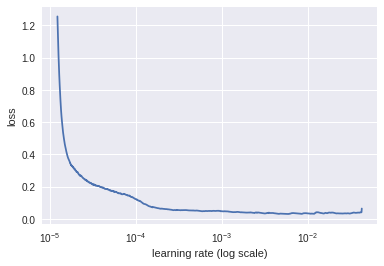

In [106]:
m.sched.plot(100)

In [0]:
lr = 1e-3

In [108]:
m.fit(lr, 3, metrics=[exp_rmspe]) # применяем свою метрику exp_rmspe

epoch      trn_loss   val_loss   exp_rmspe  
    0      0.014144   8e-06      0.00288   


    1      0.010493   0.001549   0.040145  
  0%|          | 0/6597 [00:00<?, ?it/s, loss=0.0104]

    2      0.009488   0.001056   0.031969  


[array([0.00106]), 0.031968637946800375]

In [0]:
m.fit(lr, 5, metrics=[exp_rmspe], cycle_len=1)

In [0]:
m.fit(lr, 3, metrics=[exp_rmspe], cycle_len=4)

In [0]:
m.save('val0')

In [0]:
m.load('val0')

In [0]:
x,y=m.predict_with_targs()

In [112]:
exp_rmspe(x,y)

0.031968637946800375

In [0]:
pred_test=m.predict(True)

In [0]:
pred_test = np.exp(pred_test)

In [0]:
joined_test['Sales']=pred_test

In [0]:
csv_fn=f'{PATH}tmp/sub.csv'

In [0]:
joined_test[['Id','Sales']].to_csv(csv_fn, index=False)

In [121]:
f'{PATH}tmp/sub.csv'

'data/rossmann/tmp/sub.csv'

**Случайный лес**

In [0]:
from sklearn.ensemble import RandomForestRegressor

In [0]:
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, df.values, yl)

In [0]:
m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2, n_jobs=-1, oob_score=True)

In [125]:
m.fit(trn, y_trn)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.99, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [126]:
preds = m.predict(val)
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_, exp_rmspe(preds, y_val)

(0.9825751372036499, 0.0, 0.9260912509570574, 0.08346625483525645)